<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 6: Model Selection</h2>
<br>


The tutorial on linear regression and k-Nearest Neighbours left us with two important questions: how many neighbours should we use in the kNN method? What should be our final model? In this lesson we use cross-validation to address these questions. 

<a href="#1.-Credit-Card-Data">Credit Card Data</a> <br>
<a href="#2.-Cross-Validation">Cross Validation</a> <br>
<a href="#3.-Hyperparameter-Optimisation">Hyperparameter Optimisation</a> <br>
<a href="#4.-Choosing-a-Final-Model">Choosing a Final Model</a> <br>
<a href="#5.-Model-Evaluation">Model Evaluation</a> <br>
<a href="#6.-Exercise">Exercise</a> <br>

This notebook relies on the following imports and settings. We will load new functions and libraries in context to make clear what we are using them for. 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Learning algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. Credit Card Data

We again use the `Credit` dataset. Here we simply repeat the steps from the previous notebook to load and process the data. 

In [4]:
# We will always assume that the data file is in a subdirectory called "Data"
train=pd.read_hdf('Data/Credit.h5', 'train')
test=pd.read_hdf('Data/Credit.h5', 'test')
train.head(10) 

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
400,18.701,5524,5,64,7,0,0,966,0,0,1
26,14.090,4323,5,25,16,0,1,671,0,0,0
280,54.319,3063,3,59,8,1,0,269,0,1,0
261,67.937,5184,4,63,12,0,1,345,1,0,1
131,23.793,3821,4,56,12,1,1,868,0,0,0
381,115.123,7760,3,83,14,0,0,661,0,0,0
361,53.566,5891,4,82,10,0,0,712,0,1,0
21,17.700,2860,4,63,16,0,0,89,0,0,1
193,28.508,3933,4,56,14,0,1,336,1,0,1


We'll initially consider two predictors for illustrative purposes, the credit card limit and income. 

In [5]:
# Response label
response = 'Balance'

# Response vectors 
y_train = train[response]
y_test = test[response]

### 2. Cross Validation

As our first illustration, let's consider the choice of the number of neighbours in the kNN method. We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of the learning algorithm for different values of the hyperparameter.

For purposes of this section, we'll focus on only two predictors.

In [6]:
predictors = ['Limit', 'Income'] 
X_train = train[predictors] # we'll leave it as a pandas dataframe to simplify the syntax

The [<TT>cross_val_score</TT>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from Scikit-Learn allows to computer the cross-validation error of a model.

In [7]:
# Warning! This implementation assumes that the training rows are shuffled.  
# Our train-test split already did that 

knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', metric_params={'V': X_train.cov()})

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
scores

array([-46938.3375    , -13504.56482143, -18188.13589286, -39258.8625    ,
       -13452.49964286])

Note that we specified the following options: `cv=5` specifies the number of folds, while `scoring = 'neg_mean_squared_error'` specifies the evaluation criterion. The function returns the score for each fold. Below, we average the scores and obtain the cross validation root mean squared error. 

In [8]:
rmse = np.sqrt(-1*np.mean(scores))
print(rmse)

162.0755381648587


The scoring in Scikit-Learn follows the convention that higher score values are better. This is why the argument in the function is the negative mean squared error. The Scikit-Learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. You should save this for future reference.

Often, the syntax is simplified by the fact that each method in Scikit-Learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [kNN regression](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) the default scoring is the r-squared.

Let's plot the cross validation error as a function of the hyperparameter. 

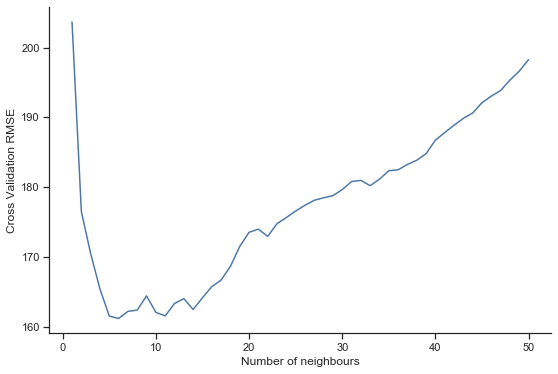

Lowest CV error: k = 6


In [9]:
n_neighbours=np.arange(1, 51)

cv_rmse = []
for k in n_neighbours: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(n_neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: k = {1 + np.argmin(cv_rmse)}')

Using `k=6` neighbours therefore leads to the lowest cross-validation error. Below, we will see how to automate the process of hyperparameter optimisation instead having to code a loop manually. 

Our sample size here is not large,  and you can see above that there is a lot of variation in the MSE across folds. This is a situation in which we should use repeated k-fold cross validation, which we can do as follows.

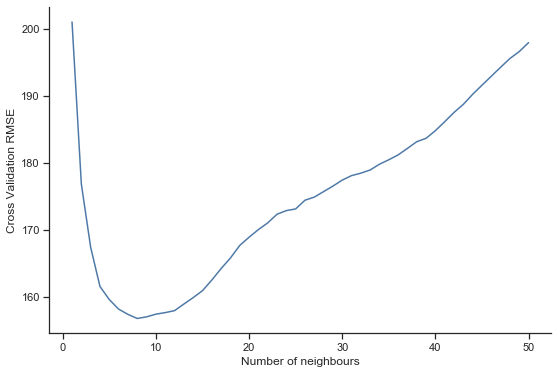

Lowest CV error: k = 8


In [10]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=44928)

n_neighbours=np.arange(1, 51)

cv_rmse = []
for k in n_neighbours: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(n_neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: k = {1 + np.argmin(cv_rmse)}')

With repeated k-fold the curve looks much smoother, which is good. We now select `k=8` neighbours instead of `k=6`. 

**Warning!** Repeated k-fold is better but can be very slow for larger datasets and more complex methods.

### 3. Hyperparameter Optimisation

What we did at the end of the last section was hyperparameter optimisation based on a grid search. Now, let's see how we can automate this process and use other methods for hyperparameter optimisation.

Though a grid search solves our problem in the current setting, it can too computationally costly when we work with large datasets and/or methods that have multiple tuning parameters. Therefore, this section also teaches you how to use randomised search and Bayesian optimisation.

**3.1 Grid search**

We implement the grid search approach as follows (this is the same as what we did manually above).  

In [11]:
from sklearn.model_selection import GridSearchCV
 
# note that we skip specifying the hyperparameter that we want to choose
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()}) 

space = {'n_neighbors': np.arange(1,51),}

# replacing cv = rkf with cv = 5 would do 5-fold cross-validation
knn_search =  GridSearchCV(model, space, cv = rkf,  scoring = 'neg_mean_squared_error',  n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x0000029B382BDE80>,
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671},
          n_jobs=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Setting `n_jobs=4` splits the task across four processor cores, which speeds up the computations. You may need to reduce this depending on your computer.

The `best_params_` attribute allows us view the selected value of the hyperparameter.  

In [12]:
knn_search.best_params_

{'n_neighbors': 8}

The selected model is stored in the `best_estimator_` attribute: 

In [13]:
knn_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671},
          n_jobs=None, n_neighbors=8, p=2, weights='uniform')

**3.2 Randomised search**

The grid-search method easily solves our problem here, but it can be too computationally costly when we have to work with larger datasets and/or methods that have multiple tuning parameters.  In this case we can instead use the  [<TT>RandomizedSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) function, which evaluates a random sample of hyperparameter configurations. 

The syntax is very similar to the above, except that we will often want to specify the `n_iter` option in order to control the computational budget for the hyperparameter seach. Below, we specify that we would like to try twenty values for the number of neighbours. 

In [14]:
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()})

space = {'n_neighbors': np.arange(1, 51)}

knn_rs =  RandomizedSearchCV(model, space, cv = rkf,  n_iter=20, scoring = 'neg_mean_squared_error',
                             return_train_score=False, n_jobs = 4, random_state = 10)
knn_rs.fit(X_train, y_train)
knn_rs.best_params_ # because of the random search, the result may be different from what we got before

{'n_neighbors': 8}

**Warning!** This is just an illustration to teach the syntax for a random search. There's no practical reason to do this here,  since a grid search is ideal if we can run it in a reasonable amount of time.

**3.3 Bayesian Hyperparameter Optimisation** 

Bayesian hyperparameter optimisation is a more complex method. The most popular Python package for Bayesian optimisation within the machine learning community is [hyperopt](http://hyperopt.github.io/hyperopt/), and it's worth exploring it. However, we'll here use the [scikit-optimize](https://scikit-optimize.github.io/)  package (you need to install it separately), which is simpler to use. 

In [15]:
from skopt.space import Integer
from skopt import BayesSearchCV

space = {'n_neighbors': Integer(1, 50)}
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()})
opt =  BayesSearchCV(model, space, cv = rkf,  n_iter = 20, random_state = 5,
                     scoring = 'neg_mean_squared_error', n_jobs = 4)
opt.fit(X_train, y_train)
opt.best_params_

{'n_neighbors': 13}

In Bayesian optimisation it's important to specify a range of hyperparametres values that you consider plausible, since this influences the result.

**Warning!** This is just an illustration to introduce the syntax for `BayesSearchCV`. There's no reason to do this here,  since a grid search is ideal if we can run it in a reasonable amount of time.

**Warning!** Bayesian hyperparameter optimisation is not necessarily better than a random search, as this example shows.  

 ### 4. Choosing a Final Model
 
Remember that our final choice of model needs to be based on the training data.  

First, we initialise the two models and find the best value of the hyperparameter for kNN. I use all the predictors for the linear regression model, and the best combination of predictors for kNN. We'll discuss variable selection later in the unit.

In [16]:
# This cell takes a few seconds to run because of repeated KF, please be patient

# kNN 
subset = ['Income', 'Limit', 'Student']
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': train[subset].cov()}) 
space = {'n_neighbors': np.arange(1,51),}
knn_search =  GridSearchCV(model, space, cv = rkf,  scoring = 'neg_mean_squared_error',  n_jobs=4)
knn_search.fit(train[subset], y_train)
knn = knn_search.best_estimator_

# Linear regression (no need to fit for now)
predictors =  [variable for variable in train.columns if variable!=response] 
ols = LinearRegression()

It's interesting to check that we selected `k=3` for kNN. 

In [17]:
knn.n_neighbors

3

Using cross validation, we estimate that kNN performs best in the current setting.

In [18]:
# Repeated k-fold would be better here, but we'll be using cv = 5 so that we can compare
# with the next part

methods = [ols, knn] 
subsets = [predictors, subset]

errors = []
for method, subset in zip(methods, subsets):
    scores = cross_val_score(method, train[subset], y_train, cv = 5, scoring = 'neg_mean_squared_error')
    errors.append(np.sqrt(-1*np.mean(scores)))
    
columns=['CV RMSE']
rows=['Linear Regression', 'kNN']
results = pd.DataFrame(0.0, columns=columns, index=rows)
results.iloc[0,0] = errors[0]
results.iloc[1,0] = errors[1]
results.round(2)

,CV RMSE
Linear Regression,105.07
kNN,89.32


Instead of selecting a single method as the final model, the best approach is usually to combine predictions from different models. We'll discuss this later in the course. As an introduction to this idea, we consider a simple average of the linear regression and kNN prediction and select the approach with lowest cross validation RMSE. 

As an additional improvement, we notice that the linear regression model generates some negative predictions, which is inconsistent with the fact that the response variable has a minimum value of zero. Therefore, we set all negative predictions to zero for this model.

The [cross_val_prediction](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function from scikit-learn allows us to do a more detailed analysis of model performance based on cross validation. 

The results show that the adjustment in the linear regression predictions leads to a substantial improvement in performance, such that it now performs better than kNN. However, an average of the two methods is even better! This is our final model to predict the test data.

In [19]:
from sklearn.model_selection import cross_val_predict

# Initialise table
columns=['CV RMSE', 'CV R-Squared', 'CV MAE']
rows=['Linear Regression', 'kNN', 'Average']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Algorithms
methods = [ols, knn] 
subsets = [predictors, subset]

# Compute CV predictions
y_pred = np.zeros((len(y_train), 3)) # initialising a matrix with three columns to store the predictions
for i, (method, subset) in enumerate(zip(methods, subsets)):
    y_pred[:, i] = cross_val_predict(method, train[subset], y_train, cv = 5)

# Fixing negative predictions in the linear regression    
y_pred[y_pred[:,0] < 0, 0] = 0

# Averaging
y_pred[:, 2] = 0.5 * y_pred[:, 0] + 0.5 * y_pred[:, 1] 

# Fill table with the results
for i in range(3):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_train, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred[:,i])

results.round(2)

,CV RMSE,CV R-Squared,CV MAE
Linear Regression,76.79,0.97,58.26
kNN,89.32,0.96,55.08
Average,67.38,0.98,47.07


### 5. Model Evaluation
 
The next cell computes the test results. We highlight three conclusions: 

1. Using cross validation to select the number of neighbours substantially improves the test performance of the kNN method compared to the previous tutorial. 

2. Based on the training data only, we correctly identified that the average of the linear regression and kNN predictions was the best approach for predicting the test data, among the options that we considered.

3. Truncating the linear regression predictions substantially improves the test perfomance compared to the previous tutorial. 

Keep in mind the distinction between model evaluation and selection! Even though the table shows the results for different models, the point is to show by using appropriate methods and analysis for the training data, we made good decisions that allowed us to predict the test data with more accuracy. 

**At no point we directly optimised performance on the test data. The reason why this all works is that the training and test data by construction random samples from the same population.**

In [20]:
# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Linear Regression', 'kNN', 'Average']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# Fitting the linear regression model
ols.fit(train[predictors], y_train)

# Compute CV predictions
y_pred = np.zeros((len(y_test), 3))
for i, (method, subset) in enumerate(zip(methods, subsets)):
    y_pred[:, i] = method.predict(test[subset])

# Fixing implausible predictions in the linear regression    
y_pred[y_pred[:,0] < 0, 0] = 0

# Averaging
y_pred[:, 2] = 0.5 * y_pred[:, 0] + 0.5 * y_pred[:, 1] 

# Test results
for i in range(3):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_test, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred[:,i])

results.round(2)

,RMSE,R-Squared,MAE
Linear Regression,76.86,0.97,61.11
kNN,81.15,0.97,49.34
Average,65.24,0.98,46.57


### 6.  Exercise

If you are looking for a challenge.  

It may be possible to improve the linear regression model further through regression modelling. You can try a bivariate polynomial for limit and income, and an interaction between limit and student. Use cross validation to decide if it's worth it to include these features into the model. 

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [21]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [22]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')